In [1]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [66]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True)

Index(['Price', 'volume', 'Trend', 'period', 'QV'], dtype='object')


In [10]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [17]:
trainer = Trainer(agent, env, capacity=10000)

In [19]:
trainer.fill_exp_replay(max_steps=1000)

/Users/g0bel1n/DDQL-optimal-execution/ddql_optimal_execution/trainer/_trainer.py:144: MaxStepsTooLowWarning: Max steps is too low. It is set to 10000.
  warnings.warn(MaxStepsTooLowWarning(max_steps))
Filling experience replay buffer:  94%|█████████▍| 9392/10000 [00:42<00:02, 221.33it/s]


In [20]:
trainer.pretrain(max_steps=1000, batch_size=32)

Pretraining agent:   2%|▏         | 19/1000 [00:01<00:42, 23.10it/s]

Target network updated at step 15 with greediness 0.46


Pretraining agent:   3%|▎         | 34/1000 [00:01<00:37, 25.49it/s]

Target network updated at step 30 with greediness 0.21


Pretraining agent:   5%|▍         | 49/1000 [00:02<00:37, 25.05it/s]

Target network updated at step 45 with greediness 0.10


Pretraining agent:   6%|▋         | 64/1000 [00:02<00:37, 25.11it/s]

Target network updated at step 60 with greediness 0.05


Pretraining agent:   8%|▊         | 79/1000 [00:03<00:34, 26.77it/s]

Target network updated at step 75 with greediness 0.02


Pretraining agent:   9%|▉         | 94/1000 [00:03<00:34, 26.53it/s]

Target network updated at step 90 with greediness 0.01


Pretraining agent:  11%|█         | 109/1000 [00:04<00:34, 25.89it/s]

Target network updated at step 105 with greediness 0.01


Pretraining agent:  12%|█▏        | 124/1000 [00:05<00:32, 27.22it/s]

Target network updated at step 120 with greediness 0.01


Pretraining agent:  14%|█▍        | 140/1000 [00:05<00:32, 26.45it/s]

Target network updated at step 135 with greediness 0.01


Pretraining agent:  16%|█▌        | 155/1000 [00:06<00:31, 27.17it/s]

Target network updated at step 150 with greediness 0.01


Pretraining agent:  17%|█▋        | 170/1000 [00:06<00:30, 27.42it/s]

Target network updated at step 165 with greediness 0.01


Pretraining agent:  18%|█▊        | 183/1000 [00:07<00:29, 27.97it/s]

Target network updated at step 180 with greediness 0.01


Pretraining agent:  20%|█▉        | 199/1000 [00:07<00:28, 27.95it/s]

Target network updated at step 195 with greediness 0.01


Pretraining agent:  21%|██▏       | 214/1000 [00:08<00:30, 26.05it/s]

Target network updated at step 210 with greediness 0.01


Pretraining agent:  23%|██▎       | 230/1000 [00:09<00:27, 27.80it/s]

Target network updated at step 225 with greediness 0.01


Pretraining agent:  24%|██▍       | 245/1000 [00:09<00:27, 27.52it/s]

Target network updated at step 240 with greediness 0.01


Pretraining agent:  26%|██▌       | 260/1000 [00:10<00:28, 26.34it/s]

Target network updated at step 255 with greediness 0.01


Pretraining agent:  28%|██▊       | 275/1000 [00:10<00:29, 24.34it/s]

Target network updated at step 270 with greediness 0.01


Pretraining agent:  29%|██▉       | 290/1000 [00:11<00:27, 26.24it/s]

Target network updated at step 285 with greediness 0.01


Pretraining agent:  30%|███       | 305/1000 [00:12<00:26, 26.27it/s]

Target network updated at step 300 with greediness 0.01


Pretraining agent:  32%|███▏      | 320/1000 [00:12<00:25, 26.53it/s]

Target network updated at step 315 with greediness 0.01


Pretraining agent:  34%|███▎      | 335/1000 [00:13<00:24, 27.21it/s]

Target network updated at step 330 with greediness 0.01


Pretraining agent:  35%|███▍      | 347/1000 [00:13<00:26, 24.62it/s]

Target network updated at step 345 with greediness 0.01


Pretraining agent:  36%|███▋      | 363/1000 [00:14<00:23, 26.67it/s]

Target network updated at step 360 with greediness 0.01


Pretraining agent:  38%|███▊      | 378/1000 [00:14<00:22, 27.79it/s]

Target network updated at step 375 with greediness 0.01


Pretraining agent:  39%|███▉      | 393/1000 [00:15<00:22, 27.20it/s]

Target network updated at step 390 with greediness 0.01


Pretraining agent:  41%|████      | 408/1000 [00:15<00:21, 27.12it/s]

Target network updated at step 405 with greediness 0.01


Pretraining agent:  42%|████▏     | 423/1000 [00:16<00:20, 27.48it/s]

Target network updated at step 420 with greediness 0.01


Pretraining agent:  44%|████▍     | 438/1000 [00:17<00:20, 27.68it/s]

Target network updated at step 435 with greediness 0.01


Pretraining agent:  45%|████▌     | 453/1000 [00:17<00:20, 26.46it/s]

Target network updated at step 450 with greediness 0.01


Pretraining agent:  47%|████▋     | 468/1000 [00:18<00:19, 26.95it/s]

Target network updated at step 465 with greediness 0.01


Pretraining agent:  48%|████▊     | 483/1000 [00:18<00:18, 27.74it/s]

Target network updated at step 480 with greediness 0.01


Pretraining agent:  50%|████▉     | 498/1000 [00:19<00:18, 27.23it/s]

Target network updated at step 495 with greediness 0.01


Pretraining agent:  51%|█████▏    | 513/1000 [00:20<00:21, 22.65it/s]

Target network updated at step 510 with greediness 0.01


Pretraining agent:  53%|█████▎    | 528/1000 [00:20<00:23, 19.92it/s]

Target network updated at step 525 with greediness 0.01


Pretraining agent:  55%|█████▍    | 545/1000 [00:21<00:19, 23.92it/s]

Target network updated at step 540 with greediness 0.01


Pretraining agent:  56%|█████▌    | 560/1000 [00:22<00:17, 25.50it/s]

Target network updated at step 555 with greediness 0.01


Pretraining agent:  57%|█████▋    | 572/1000 [00:22<00:17, 24.97it/s]

Target network updated at step 570 with greediness 0.01


Pretraining agent:  59%|█████▉    | 590/1000 [00:23<00:15, 26.84it/s]

Target network updated at step 585 with greediness 0.01


Pretraining agent:  60%|██████    | 605/1000 [00:23<00:14, 27.71it/s]

Target network updated at step 600 with greediness 0.01


Pretraining agent:  62%|██████▏   | 620/1000 [00:24<00:14, 27.03it/s]

Target network updated at step 615 with greediness 0.01


Pretraining agent:  64%|██████▎   | 635/1000 [00:25<00:14, 25.80it/s]

Target network updated at step 630 with greediness 0.01


Pretraining agent:  65%|██████▌   | 650/1000 [00:25<00:12, 27.49it/s]

Target network updated at step 645 with greediness 0.01


Pretraining agent:  66%|██████▋   | 665/1000 [00:26<00:12, 26.93it/s]

Target network updated at step 660 with greediness 0.01


Pretraining agent:  68%|██████▊   | 681/1000 [00:26<00:11, 28.30it/s]

Target network updated at step 675 with greediness 0.01


Pretraining agent:  69%|██████▉   | 693/1000 [00:27<00:10, 28.41it/s]

Target network updated at step 690 with greediness 0.01


Pretraining agent:  71%|███████   | 708/1000 [00:27<00:10, 27.70it/s]

Target network updated at step 705 with greediness 0.01


Pretraining agent:  72%|███████▏  | 723/1000 [00:28<00:10, 25.35it/s]

Target network updated at step 720 with greediness 0.01


Pretraining agent:  74%|███████▍  | 738/1000 [00:28<00:09, 27.16it/s]

Target network updated at step 735 with greediness 0.01


Pretraining agent:  75%|███████▌  | 753/1000 [00:29<00:09, 26.93it/s]

Target network updated at step 750 with greediness 0.01


Pretraining agent:  77%|███████▋  | 768/1000 [00:30<00:08, 26.66it/s]

Target network updated at step 765 with greediness 0.01


Pretraining agent:  78%|███████▊  | 783/1000 [00:30<00:08, 26.96it/s]

Target network updated at step 780 with greediness 0.01


Pretraining agent:  80%|███████▉  | 798/1000 [00:31<00:07, 27.33it/s]

Target network updated at step 795 with greediness 0.01


Pretraining agent:  81%|████████▏ | 813/1000 [00:31<00:08, 22.50it/s]

Target network updated at step 810 with greediness 0.01


Pretraining agent:  83%|████████▎ | 828/1000 [00:32<00:06, 25.40it/s]

Target network updated at step 825 with greediness 0.01


Pretraining agent:  84%|████████▍ | 843/1000 [00:33<00:05, 27.40it/s]

Target network updated at step 840 with greediness 0.01


Pretraining agent:  86%|████████▌ | 858/1000 [00:33<00:05, 27.13it/s]

Target network updated at step 855 with greediness 0.01


Pretraining agent:  87%|████████▋ | 873/1000 [00:34<00:04, 25.58it/s]

Target network updated at step 870 with greediness 0.01


Pretraining agent:  89%|████████▉ | 888/1000 [00:34<00:04, 27.25it/s]

Target network updated at step 885 with greediness 0.01


Pretraining agent:  90%|█████████ | 904/1000 [00:35<00:03, 27.41it/s]

Target network updated at step 900 with greediness 0.01


Pretraining agent:  92%|█████████▏| 919/1000 [00:35<00:02, 27.61it/s]

Target network updated at step 915 with greediness 0.01


Pretraining agent:  93%|█████████▎| 934/1000 [00:36<00:02, 26.95it/s]

Target network updated at step 930 with greediness 0.01


Pretraining agent:  95%|█████████▍| 949/1000 [00:37<00:01, 28.14it/s]

Target network updated at step 945 with greediness 0.01


Pretraining agent:  96%|█████████▋| 964/1000 [00:37<00:01, 26.69it/s]

Target network updated at step 960 with greediness 0.01


Pretraining agent:  98%|█████████▊| 979/1000 [00:38<00:00, 27.30it/s]

Target network updated at step 975 with greediness 0.01


Pretraining agent:  99%|█████████▉| 994/1000 [00:38<00:00, 27.58it/s]

Target network updated at step 990 with greediness 0.01


Pretraining agent: 100%|██████████| 1000/1000 [00:38<00:00, 25.67it/s]


In [52]:
trainer.train(max_steps=10000, batch_size=128)

Training agent:   5%|▌         | 6/120 [00:01<00:21,  5.30it/s]

Target network updated at step 1125 with greediness 0.01


Training agent:  18%|█▊        | 21/120 [00:04<00:19,  5.20it/s]

Target network updated at step 1140 with greediness 0.01


Training agent:  31%|███       | 37/120 [00:07<00:15,  5.28it/s]

Target network updated at step 1155 with greediness 0.01


Training agent:  42%|████▎     | 51/120 [00:09<00:12,  5.34it/s]

Target network updated at step 1170 with greediness 0.01


Training agent:  55%|█████▌    | 66/120 [00:12<00:09,  5.40it/s]

Target network updated at step 1185 with greediness 0.01


Training agent:  68%|██████▊   | 81/120 [00:15<00:07,  5.19it/s]

Target network updated at step 1200 with greediness 0.01


Training agent:  80%|████████  | 96/120 [00:18<00:04,  5.51it/s]

Target network updated at step 1215 with greediness 0.01


Training agent:  92%|█████████▎| 111/120 [00:20<00:01,  5.59it/s]

Target network updated at step 1230 with greediness 0.01


Training agent: 100%|██████████| 120/120 [00:22<00:00,  5.28it/s]


In [67]:
env.state

{'Price': -1.0384259343885265,
 'volume': -0.7060709885136738,
 'Trend': -0.6505891750175585,
 'period': 0.0,
 'QV': -0.43387330989951606,
 'inventory': 500}

In [81]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
env.reset()

twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)

pnl_twap = []
pnl_ddql = []

random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)

for ep in random_ep:
    env.swap_episode(ep)
    _pnl_twap = [0]
    while not env.done:
        current_state = env.state.copy()
        action = twap(current_state)
        _ = env.step(action)
        _pnl_twap.append(env.state['Price']*action)
    pnl_twap.append(_pnl_twap)

    env.reset()
    _pnl_ddql = [0]
    while not env.done:
        current_state = env.state.copy()
        action = trainer.agent(current_state)
        _ = env.step(action)
        _pnl_ddql.append(env.state['Price']*action)
    pnl_ddql.append(_pnl_ddql)

In [82]:
pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)

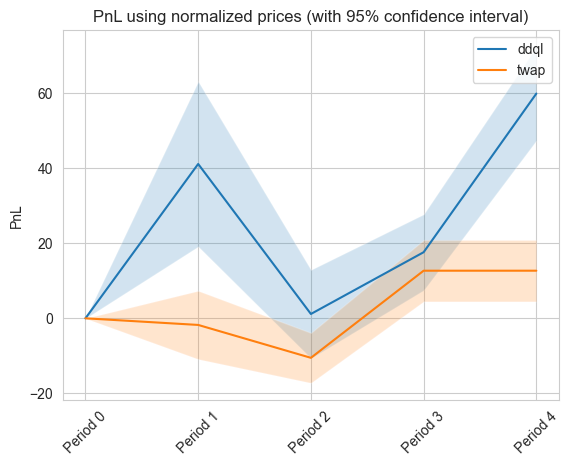

In [83]:
confidence_level = .95

plt.plot(pnl_ddql.mean(axis=0), label='ddql')
plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.2)
plt.plot(pnl_twap.mean(axis=0), label='twap')
plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.2)
plt.legend()
plt.xticks(
    rotation=45, ticks=range(5), labels=[f"Period {i}" for i in range(5)]
)

plt.title(r'PnL using normalized prices (with 95% confidence interval)')
plt.ylabel('PnL')
plt.show()

Text(0.5, 0, 'PnL')

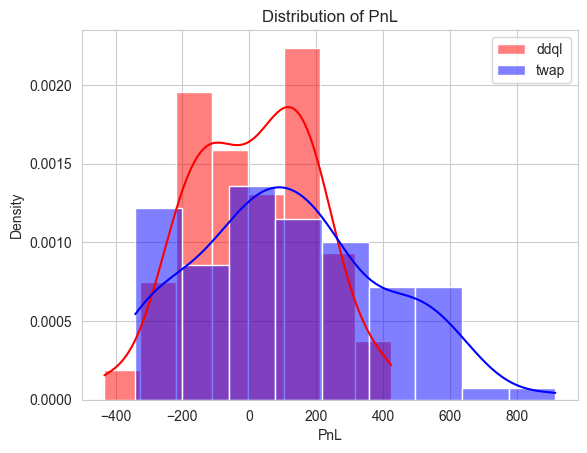

In [84]:
#distribution of rewards



sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='density', color='red', alpha=.5)
sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='density', color='blue', alpha=.5)
plt.legend()
plt.title('Distribution of PnL')
plt.xlabel('PnL')

In [6]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")